In [41]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.table import Table, join, Column

from astropy.io import ascii
import glob, re

% matplotlib inline

import matplotlib as mpl
mpl.style.use('seaborn-colorblind')

#To make sure we have always the same matplotlib settings
#(the ones in comments are the ipython notebook settings)

mpl.rcParams['figure.figsize']=(12.0,9.0)    #(6.0,4.0)
mpl.rcParams['font.size']=18               #10 
mpl.rcParams['savefig.dpi']= 200             #72 
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
from matplotlib import rc

colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']


## This notebook reads in Keith's abundances and Guy's asteroseismology to produce the tables for the paper.

In [42]:
fname_diff = "../data/abundances/Pope_abundances_diff_arcturus.fits"
fname_nodiff = "../data/abundances/Pope_abundances_nodiff.fits"

In [43]:
diff = Table.read(fname_diff)
diff.sort('Object')
nodiff = Table.read(fname_nodiff)
nodiff.sort('Object')

How do abundances compare between the differential and non-differential methods? Not too badly. Many more elements lack differential abundances than absolute abundances so it looks like in the paper we shouldn't use the differential. Good to include in online data though.

In [44]:
# for j, key in enumerate(diff.keys()[1:]):
#     if key[0]=='e':
#         continue
#     plt.figure(j)
#     plt.plot(diff[key],nodiff[key],'.')
#     plt.title(key)

In [45]:
nodiff

Object,Ca_Fe,eCa_Fe,Mg_Fe,eMg_Fe,Si_Fe,eSi_Fe,Ti_Fe,eTi_Fe,O_Fe,eO_Fe,Al_Fe,eAl_Fe,Ba_Fe,eBa_Fe,Na_Fe,eNa_Fe,Ni_Fe,eNi_Fe,Mn_Fe,eMn_Fe,Co_Fe,eCo_Fe,Eu_Fe,eEu_Fe,La_Fe,eLa_Fe,Zr_Fe,eZr_Fe,Sr_Fe,eSr_Fe,Zn_Fe,eZn_Fe,Y_Fe,eY_Fe,Cr_Fe,eCr_Fe,V_Fe,eV_Fe,Cu_Fe,eCu_Fe,Sc_Fe,eSc_Fe
str10,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
BD+36_3564,0.20550000000000068,0.021811959427664313,0.32699999999999996,0.029981933288751386,0.1030000000000002,0.03033791174238739,0.3414999999999999,0.039563195412588896,nan,nan,0.39749999999999996,0.008838834764831969,nan,nan,0.2600000000000007,0.07726769244837267,0.006000000000000227,0.04284999081677555,0.07750000000000057,0.0045961940777125235,0.1299999999999999,0.023192941522005114,0.24799999999999933,0.02768573639981425,-0.016499999999999737,0.0659359300760974,0.10200000000000031,0.021922773547158676,0.3440000000000003,0.11825713509129157,-0.28699999999999903,0.19772933239377738,-0.2739999999999996,0.015773296262988193,0.23000000000000043,0.003797614382740828,0.1535000000000002,0.03049898435435564,-0.04499999999999971,0.06190150947270998,0.17300000000000093,0.017790381816734174
BD+39_3577,0.1330000000000009,0.024249415323230328,0.2150000000000003,0.03658925303282372,-0.10549999999999926,0.02174089847882709,0.08499999999999996,0.03879026485998592,nan,nan,0.20550000000000024,0.00954594154601844,0.3520000000000003,0.1010273157048059,0.41600000000000037,0.0,-0.051000000000000156,0.03328029088036782,-0.028999999999999027,0.05782989102787844,-0.015999999999999126,0.02072659732649556,-0.22100000000000009,0.04160228359116841,-0.254999999999999,0.015035759843588615,0.128000000000001,0.08221016968721083,nan,nan,-0.24099999999999877,0.7076482176901175,-0.4039999999999999,0.037289656991162025,0.1640000000000006,0.0952853444922145,0.010500000000000398,0.020276010901452025,-0.20599999999999952,0.012727922061357708,-0.12499999999999956,0.053405093390050375
BD+43_3064,0.18600000000000083,0.042992624259758146,0.2110000000000003,0.03401960219246152,-0.013999999999999346,0.030231207814540438,0.28249999999999975,0.044954827587674044,nan,nan,0.3550000000000004,0.010606601717797986,nan,nan,0.4790000000000001,0.06424951361683594,0.052999999999999936,0.044591812612475384,0.21400000000000086,0.024748737341528947,0.1330000000000009,0.02184520148655853,0.28000000000000025,0.05847007781763251,0.14950000000000063,0.017140503930748237,0.3230000000000004,0.03883977342879325,0.24800000000000022,0.12460813576970005,nan,nan,-0.13999999999999968,0.051714601419715026,0.32200000000000095,0.013075280607427315,0.24100000000000055,0.034289644203321076,-0.15899999999999936,0.09666551723454563,0.13700000000000045,0.024837935349126893
BD+43_3171,0.28550000000000075,0.027774123216385355,0.2570000000000001,0.06383866383313486,-0.0004999999999997229,0.06954906181969671,0.20650000000000013,0.05828622108614094,nan,nan,0.4225000000000003,0.012968712349342808,0.32650000000000023,0.17867480936046912,0.18350000000000044,0.24711535767734086,0.04100000000000037,0.05452977168483287,0.1095000000000006,0.0947523086789976,0.1385000000000005,0.05128187695268264,0.2134999999999998,0.04800520805079382,-0.057999999999999385,0.11110636795431662,0.3585000000000007,0.06505382386916242,nan,nan,-0.40499999999999936,0.05055813485483807,-0.3059999999999996,0.030052038200428254,0.2940000000000005,0.03995153313703977,0.12350000000000039,0.056319659089877294,0.017000000000000348,0.10812319362652953,0.1435000000000004,0.032129667788764645
BD+43_3213,0.1880000000000006,0.02661522816679147,0.22599999999999998,0.07206097859790929,-0.1779999999999995,0.11026558846711877,0.2709999999999999,0.06893329102190833,nan,nan,0.37200000000000033,0.038890872965260226,nan,nan,0.6230000000000002,0.367428

In [46]:
elements = filter(lambda x: x[0]!='e', nodiff.keys()[1:])
print elements

### Create a string-formatted table merging abundances with their uncertainties appropriately.

In [47]:
newtab = Table([Column([str(obj).replace('_',' ') for obj in nodiff['Object']],name='Object')])

for el in elements[:8]:
    if el == 'O_Fe':
        continue
    col = nodiff[el]
    ecol = nodiff['e%s' % el]
    test = Column(['--' if 'nan' in str(col[j]) else '$%.2f \pm %.2f$' % (col[j],ecol[j]) for j, x in enumerate(col)],name='[%s/Fe]' % el.replace('_Fe',''))
#     test = Column(['$%.2f \pm %.2f$' % (col[j],ecol[j]) for j, x in enumerate(col)],name=el.replace('_Fe',''))

    newtab.add_column(test)
    
#     print el


newtab2 = Table([Column([str(obj).replace('_',' ') for obj in nodiff['Object']],name='Object')])

for el in elements[8:15]:
    col = nodiff[el]
    ecol = nodiff['e%s' % el]
    test = Column(['--' if 'nan' in str(col[j]) else '$%.2f \pm %.2f$' % (col[j],ecol[j]) for j, x in enumerate(col)],name='[%s/Fe]' % el.replace('_Fe',''))
#     test = Column(['$%.2f \pm %.2f$' % (col[j],ecol[j]) for j, x in enumerate(col)],name=el.replace('_Fe',''))

    newtab2.add_column(test)
    
newtab3 = Table([Column([str(obj).replace('_',' ') for obj in nodiff['Object']],name='Object')])

for el in elements[15:]:
    col = nodiff[el]
    ecol = nodiff['e%s' % el]
    test = Column(['--' if 'nan' in str(col[j]) else '$%.2f \pm %.2f$' % (col[j],ecol[j]) for j, x in enumerate(col)],name='[%s/Fe]' % el.replace('_Fe',''))
#     test = Column(['$%.2f \pm %.2f$' % (col[j],ecol[j]) for j, x in enumerate(col)],name=el.replace('_Fe',''))

    newtab3.add_column(test)

    
# newtab_diff = Table([diff['Object']])

# for el in elements:
#     col = diff[el]
#     ecol = diff['e%s' % el]
#     test = Column(['--' if 'nan' in str(col[j]) else '%.2f $\pm$ %.2f' % (col[j],ecol[j]) for j, x in enumerate(col)],name=el.replace('_Fe',''))
# #     test = Column(['$%.2f \pm %.2f$' % (col[j],ecol[j]) for j, x in enumerate(col)],name=el.replace('_Fe',''))

#     newtab_diff.add_column(test)


In [48]:
def oxford_join(string_list):
    '''From https://stackoverflow.com/questions/19838976/grammatical-list-join-in-python'''
    if len(string_list) < 1:
        text = ''
    elif len(string_list) == 1:
        text = string_list[0]
    elif len(string_list) == 2:
        text = ' and '.join(string_list)
    else:
        text = ', '.join(string_list)
        text = '{parts[0]}, and {parts[2]}'.format(parts=text.rpartition(', '))  # oxford comma
    return text

## Now produce three LaTeX tables to go into the paper directory.

In [49]:
latexdict = ascii.latex.latexdicts['AA'].copy()
latexdict['tabletype']= 'table*'

caption1 = r'Chemical abundances relative to iron for stars in the red giant sample as determined by BACCHUS, without differential line-by-line comparison to Arcturus, as described in Section~\ref{spectroscopy}, for the elements %s. Dashes indicate elements for which abundances could not be reliably computed.' % oxford_join([el.replace('_Fe','') for el in filter(lambda x: x !='O_Fe',elements[0:8])])
caption2 = r'Chemical abundances relative to iron for stars in the red giant sample as determined by BACCHUS, without differential line-by-line comparison to Arcturus, as described in Section~\ref{spectroscopy}, for the elements %s. Dashes indicate elements for which abundances could not be reliably computed.' % oxford_join([el.replace('_Fe','') for el in elements[8:15]])
caption3 = r'Chemical abundances relative to iron for stars in the red giant sample as determined by BACCHUS, without differential line-by-line comparison to Arcturus, as described in Section~\ref{spectroscopy}, for the elements %s. Dashes indicate elements for which abundances could not be reliably computed.' % oxford_join([el.replace('_Fe','') for el in elements[15:]])

caption1 = caption1+r'The catalogue of abundances for more elements continues in Tables~\ref{elems2} and~\ref{elems3}.'
caption2 = caption2+r'The catalogue of abundances for more elements continues in Table~\ref{elems3}.'


newtab.write('../paper/abundances_1.tex',format='latex',latexdict=latexdict,caption=caption1+'\label{elems1}',overwrite=True)
newtab2.write('../paper/abundances_2.tex',format='latex',latexdict=latexdict,caption=caption2+'\label{elems2}',overwrite=True)
newtab3.write('../paper/abundances_3.tex',format='latex',latexdict=latexdict,caption=caption3+'\label{elems3}',overwrite=True)

### Now let's also do the stellar properties

In [50]:
fname_merged ="../data/abundances/final_pope_merged.fits"
merged = Table.read(fname_merged)
merged.rename_column('RVerr','RV_err')
merged.keys()
merged.sort('Object')

In [51]:
newtab = Table([Column([str(obj).replace('_',' ') for obj in merged['Object']],name='Object')])

newkeys = ['RV', 'Teff', 'logg', 'monh','vsini','SNRe']
names = [r'RV',r'\teff', r'\logg',r'[M/H]',r'$V\sin{i}$',r'SNR']
units = [r'(km/s)', r'(K)', '','','(km/s)','']

for k, key in enumerate(newkeys):
    col = merged[key]
    if key+'_err' in merged.keys():
        ecol = merged['%s_err' % key]
        if 'Teff' in key:
            test = Column(['--' if 'nan' in str(col[j]) else '$%.0f \pm %.0f$' % (col[j],ecol[j]) for j, x in enumerate(col)],name=names[k])
        else:
            test = Column(['--' if 'nan' in str(col[j]) else '$%.2f \pm %.2f$' % (col[j],ecol[j]) for j, x in enumerate(col)],name=names[k])
    else:
        test = Column(['%.1f' % (col[j]) for j, x in enumerate(col)],name=names[k])
    
    newtab.add_column(test)


In [52]:
newtab

Object,RV,\teff,\logg,[M/H],$V\sin{i}$,SNR
str10,str17,str13,str15,str16,str16,str5
BD+36 3564,$-77.84 \pm 0.05$,$4301 \pm 50$,$2.06 \pm 0.10$,$-0.34 \pm 0.08$,$5.14 \pm 0.50$,71.8
BD+39 3577,$-14.81 \pm 0.07$,$5079 \pm 50$,$3.00 \pm 0.10$,$-0.11 \pm 0.08$,$3.98 \pm 0.50$,92.8
BD+43 3064,$-13.65 \pm 0.06$,$4266 \pm 50$,$2.03 \pm 0.10$,$-0.21 \pm 0.08$,$5.17 \pm 0.50$,69.2
BD+43 3171,$-16.32 \pm 0.11$,$4072 \pm 50$,$2.02 \pm 0.10$,$-0.17 \pm 0.08$,$5.68 \pm 0.50$,68.6
BD+43 3213,$-14.16 \pm 0.16$,$4131 \pm 50$,$2.07 \pm 0.10$,$0.07 \pm 0.08$,$6.24 \pm 0.50$,57.3
BD+48 2955,$1.66 \pm 0.04$,$4344 \pm 50$,$2.11 \pm 0.10$,$-0.32 \pm 0.08$,$4.78 \pm 0.50$,31.7
...,...,...,...,...,...,...
HD 185286,$-13.70 \pm 0.08$,$4301 \pm 50$,$2.08 \pm 0.10$,$-0.14 \pm 0.08$,$5.16 \pm 0.50$,135.6
HD 185351,$-5.18 \pm 0.04$,$5244 \pm 50$,$3.66 \pm 0.10$,$0.03 \pm 0.08$,$2.02 \pm 0.50$,202.3


In [53]:
latexdict = ascii.latex.latexdicts['AA'].copy()
latexdict['tabletype']= 'table*'
latexdict['units'] = dict(zip(names,units))

caption = r'Fundamental stellar parameters for the red giant sample as determined jointly by asteroseismology (asteroseismic \logg; Section~\ref{asteroseismology}) and spectroscopy (%s; Section~\ref{spectroscopy}.)' % oxford_join(names)  
caption = caption+r'\label{stellar_props}'
newtab.write('../paper/stellar_props.tex',format='latex',latexdict=latexdict,caption=caption+'\label{stellar_props}',overwrite=True)


### Now let's look at the proper spectroscopy with Dnu measurements

In [54]:
fname_seismic = "../data/smear_Dnu.csv"
seismic = Table.read(fname_seismic)
seismic.sort('Star_ID')

In [55]:
seismic

Star_ID,Dnu,Dnu_err,Numax,Numax_err,eps,eps_err
str10,float64,float64,float64,float64,float64,float64
BD+36_3564,0.9490949804411055,0.030097283743239316,5.079062736733746,0.09882652247868091,0.8305746287171062,0.20003026391376488
BD+39_3577,1.6836250688792482,0.01363988821142889,13.266855807051439,0.31633186319569034,0.7409609522947077,0.06299253167276896
BD+42_3150,4.221788591943251,0.028504804862306103,38.315943379269186,0.9588694546996247,0.7013731801198373,0.07075600621249865
BD+43_3171,0.41728859981040545,0.05318387492844148,1.984298734336489,0.05145104900196677,0.8040170562496404,0.17159665699501567
BD+43_3213,0.48750734592283734,0.006958633078022336,2.5632797174106847,0.06325084146747773,1.0124195735754942,0.07326685394355063
BD+48_2904,2.8511597676805804,0.010318892608438912,23.13453453354469,0.7225398099392429,0.8563054208127122,0.08052669688943252
...,...,...,...,...,...,...
HD_182694,5.71435782334927,0.014267235676153614,69.7756254063585,1.017847172490138,0.9395935999968813,0.2516523703726711
HD_183124,4.3919882085523305,0.013079012313137814,39.585673622735754,0.2876104937870424,0.9451337192882556,0.027794156928306737


In [56]:
newtab = Table([Column([str(obj).replace('_',' ') for obj in seismic['Star_ID']],name='Object')])

newkeys = ['Dnu', 'Numax', 'eps']
names = [r'\Dnu',r'\numax', r'$\epsilon$']
units = [r'(\muHz)', r'(\muHz)','']

for k, key in enumerate(newkeys):
    col = seismic[key]
    if key+'_err' in seismic.keys():
        ecol = seismic['%s_err' % key]
        if 'Teff' in key:
            test = Column(['--' if 'nan' in str(col[j]) else '$%.0f \pm %.0f$' % (col[j],ecol[j]) for j, x in enumerate(col)],name=names[k])
        else:
            test = Column(['--' if 'nan' in str(col[j]) else '$%.2f \pm %.2f$' % (col[j],ecol[j]) for j, x in enumerate(col)],name=names[k])
    else:
        test = Column(['%.1f' % (col[j]) for j, x in enumerate(col)],name=names[k])
    
    newtab.add_column(test)

latexdict = ascii.latex.latexdicts['AA'].copy()
latexdict['tabletype']= 'table'
latexdict['units'] = dict(zip(names,units))

caption = r'Bulk asteroseismic parameters %s for the red giant sample as discussed in Section~\ref{asteroseismology}.' % oxford_join(names)  
caption = caption+r'\label{astero_table}'
newtab.write('../paper/astero_table.tex',format='latex',latexdict=latexdict,caption=caption+'\label{stellar_props}',overwrite=True)


### Notes on individual stars from Guy Davies

BD+39_388 - No secure detection.

BD+43_306 - Big peaks but not consistent enough with RG pattern.

HD_179959 - Pattern is too complicated - is this two stars??  Literature says no.

HD_185351 - Odd mode envelope - No explanation.

HD_187217 - No info on this star - maybe a double but very difficult to tell.

HD_188639 - Too difficult to get a robust Dnu.

HD_188875 -  Too difficult to get a robust Dnu.

HD_188629 - Too difficult to get a robust Dnu.



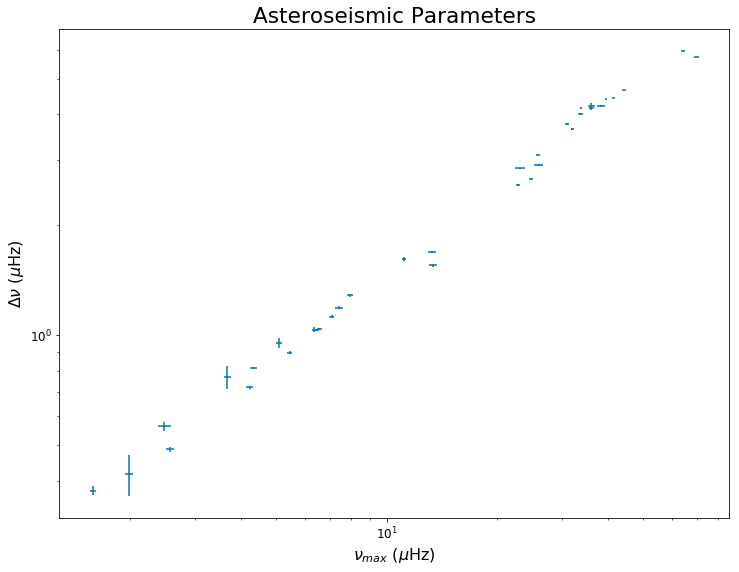

In [57]:
# the stars follow the expected numax-Dnu relation
plt.errorbar(seismic['Numax'],seismic['Dnu'],xerr=seismic['Numax_err'],yerr=seismic['Dnu_err'],linestyle='none')
plt.xlabel(r'$\nu_{max}$ ($\mu$Hz)')
plt.ylabel(r'$\Delta\nu$ ($\mu$Hz)')
plt.title('Asteroseismic Parameters')
plt.xscale('log')
plt.yscale('log')

### Which ones are missing?

In [58]:
badstars = ['BD+39_388','BD+43_306','HD_179959','HD_185351','HD_187217','HD_188639','HD_188875','HD_188629']
notes = ['No secure detection','Not consistent with RG pattern','Possible contamination',r'\citep{2017MNRAS.464.3713H}',
         'Possible contamination or binary',r'Too difficult to get a robust \Dnu',r'Too difficult to get a robust \Dnu',
         r'Too difficult to get a robust \Dnu']

notecol = [notes[j] if star in badstars else '' for j, star in enumerate(seismic['Star_ID'])]

In [59]:
np.sort(badstars)

array(['BD+39_388', 'BD+43_306', 'HD_179959', 'HD_185351', 'HD_187217',
       'HD_188629', 'HD_188639', 'HD_188875'], dtype='|S9')

In [60]:
for star in merged['Object']:
    if star[:9] not in seismic['Star_ID']:
        print star[:9]

In [61]:
for star in seismic['Star_ID']:
    if star not in merged['Object'].astype('S9'):
        print star

## Read the main catalogue

In [62]:
fname_cat = '../data/catalogue.csv'
cat = Table.read(fname_cat,format='ascii')
cat.sort('kepmag')

In [63]:
cat

Name,SpType,[Fe/H],theta,Observed,Seasons,Teff,Log_G,E(B-V),g,r,J,kepmag,Edge_Dist,Notes,Collaborators,Interferometry?,TRES?
str10,str15,float64,float64,str29,int64,int64,float64,float64,float64,float64,float64,float64,int64,str84,str16,str3,str3
HD_185351,G9IIIbCN,0.16,1.156,LC:Q1-3 SC:Q16 under,4,--,--,--,6.091,5.176,3.654,5.034,59,RG: Retired A star,Hjorringgaard,--,Yes
HD_186155,F5II-III,0.3,0.57,LC:Q1 under,4,--,--,--,5.44,5.065,4.419,5.055,66,three sharp peaks,--,--,--
HD_175740,G8III,-0.1,1.035,unobserved,4,--,--,--,6.486,5.462,4.08,5.212,0,RG: suppressed l=1,"Tim W, Guy, Cleo",Yes,Yes
HD_184875,A2V,--,0.349,unobserved,4,--,--,--,5.399,5.337,5.128,5.403,0,Classical Pulsator,--,--,--
14_Cyg,B9III,0.08,0.267,unobserved,4,--,--,--,5.334,5.394,5.365,5.49,0,"contact binary, interesting ramp at low freq",--,--,--
HD_189178,B5V,--,0.236,unobserved,4,--,--,--,5.356,5.448,5.595,5.552,0,Classical Pulsator,--,--,--
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BD+43_3064,K5,--,--,unobserved,3,--,--,--,10.18,8.692,6.205,8.284,0,RG,--,--,--
BD+43_3068,G0,--,--,unobserved,4,5506,4.394,0.011,8.754,8.254,7.181,8.308,0,not good,--,--,--


In [64]:
print 'Clump Candidates:',oxford_join([name.replace('_',' ') for name in cat[np.array(['clump' in thing for thing in list(cat['Notes'].data.data[:])])]['Name']])

### Now to get SIMBAD queries

In [65]:
from astroquery.simbad import Simbad
from astropy import coordinates as coord
from astropy import units as u


In [66]:
Simbad.reset_votable_fields()
Simbad.add_votable_fields('sptype')
sim = Simbad.query_objects(cat['Name'])
sim.write('smear_intermediate.csv',overwrite=True)
sim = Table.read('smear_intermediate.csv')
c = coord.SkyCoord(ra=sim['RA'], dec=sim['DEC'],unit=(u.hourangle, u.deg), frame='icrs')


In [67]:
new = Table([Column([cc.ra.deg for cc in c],name='RA',unit='deg',description='RA'),Column([cc.dec.deg for cc in c],name='Dec',unit='deg',description='Dec')],masked=False)
new.write('smear_simbad.csv')

We then use the gaia tap service at http://gaia.ari.uni-heidelberg.de/tap.html for crossmatch 
using the command

SELECT bj.source_id, sm.ra, sm.dec, sm.phot_g_mean_mag, bj.r_est, bj.r_lo, bj.r_hi
FROM gaiadr2_complements.geometric_distance as bj 
JOIN TAP_UPLOAD.smear AS sm ON sm.source_id = bj.source_id

In [68]:
dists = Table.read('../data/gaia_dists.csv')
# V2083_Cyg doesn't have a parallax
dists.insert_row(38,
                 vals={'source_id':2128480311802353536,'ra':292.818076238,'dec':47.481042633,
                       'phot_g_mean_mag':6.81,'r_est':np.nan,'r_lo':np.nan,'r_hi':np.nan})

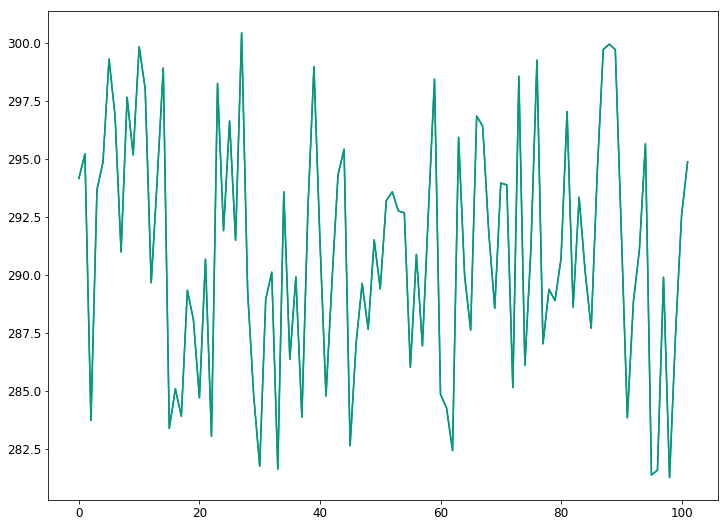

In [69]:
plt.plot(new['RA'])
plt.plot(dists['ra'])
# plt.xlim(35,45)

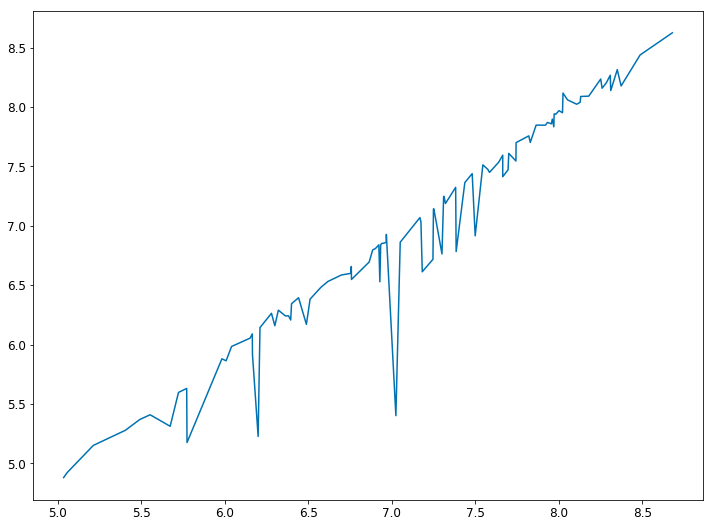

In [70]:
plt.plot(cat['kepmag'],dists['phot_g_mean_mag'])

In [71]:
cat[np.abs(dists['phot_g_mean_mag']-cat['kepmag'])>0.75]#.sort(np.abs(dists['phot_g_mean_mag']-cat['kepmag']))

Name,SpType,[Fe/H],theta,Observed,Seasons,Teff,Log_G,E(B-V),g,r,J,kepmag,Edge_Dist,Notes,Collaborators,Interferometry?,TRES?
str10,str15,float64,float64,str29,int64,int64,float64,float64,float64,float64,float64,float64,int64,str84,str16,str3,str3
V547_Lyr,M4IIIa,--,--,unobserved,4,--,--,--,8.109,6.611,2.258,6.199,48,RG: low freq,--,--,--
V398_Lyr,M3,--,--,unobserved,4,--,--,--,8.877,7.421,1.869,7.024,49,RG,--,--,--


In [72]:
dists[np.abs(dists['phot_g_mean_mag']-cat['kepmag'])>0.75]#.sort(np.abs(dists['phot_g_mean_mag']-cat['kepmag']))

source_id,ra,dec,phot_g_mean_mag,r_est,r_lo,r_hi
int64,float64,float64,float64,float64,float64,float64
2103815448491466496,285.0794350340927,40.683934166877044,5.227579,288.920092314708,276.921626546759,301.985143696241
2100382189073830528,287.05494859817054,39.154894446731085,5.4027195,494.665556977779,464.050015806101,529.522722362535


In [73]:
# sim

In [74]:
newcat = cat.copy()
newcat['SpType']=sim['SP_TYPE']
for col in dists.columns:
    newcat.add_column(dists[col])

In [75]:
# for l, ccat in enumerate([cat[:52],cat[52:]]):

#     newtab = Table([Column([str(obj).replace('_',' ') for obj in ccat['Name']],name='Object')])

#     newkeys = ['SpType','kepmag', 'Observed', 'Seasons','TRES?']
#     names = [r'Spectral Type',r'$Kp$', r'Observed',r'Seasons','Spectroscopy']
#     units = [r'(SIMBAD)', r'(mag)','','','']

#     for k, key in enumerate(newkeys):
#         col = ccat[key]
#         if 'bs' in key:
#             test = Column([entry.replace('under','') if 'under' in entry else 'unobserved' for entry in col],name=names[k])
#         elif key != 'TRES?':
#             test = Column(col.data,name=names[k])
#         if key == 'TRES?':
#             test = Column(['TRES' if newtab['Object'][j].replace(' ','_') in merged['Object'] else '--' for j,entry in enumerate(col)], name=names[k])
#         newtab.add_column(test)
    
#     latexdict = ascii.latex.latexdicts['AA'].copy()
#     latexdict['tabletype']= 'table*'
#     latexdict['units'] = dict(zip(names,units))
#     if l == 0:
#         caption = r'The full set of underobserved and unobserved stars for which new light curves have been produced in this smear catalogue. Some objects, such as HD 185351, were observed in long cadence in some quarters and short cadence in others, and this is noted accordingly.' 
#         caption = caption+r'\label{all_stars}'
#         newtab.write('../paper/all_stars.tex',format='latex',latexdict=latexdict,caption=caption+'\label{all_stars}',overwrite=True)
#         print 'Written %s' % '../paper/all_stars.tex'
#     else:
#         latexdict['preamble'] = '\contcaption{The full set of underobserved and unobserved stars for which new light curves have been produced in this smear catalogue.  \label{all_stars_cont}}'
#         newtab.write('../paper/all_stars2.tex',format='latex',latexdict=latexdict,overwrite=True)
#         print 'Written %s' % '../paper/all_stars2.tex'


In [76]:
for l, ccat in enumerate([newcat[:52],newcat[52:]]):

    newtab = Table([Column([str(obj).replace('_',' ') for obj in ccat['Name']],name='Object')])

    newkeys = ['SpType','kepmag', 'phot_g_mean_mag','r_est','source_id','Observed', 'Seasons','TRES?',]
    names = [r'Spectral Type',r'$Kp$',r'$G$',r'\gaia Distance',r'\gaia ID', r'Observed',r'Seasons','Spectroscopy']
    units = [r'(SIMBAD)', r'(mag)','(mag)','(pc)','','','']

    for k, key in enumerate(newkeys):
        col = ccat[key]
        if 'bs' in key:
            test = Column([entry.replace('under','') if 'under' in entry else 'unobserved' for entry in col],name=names[k])
        elif 'est' in key:
            upcol = ccat['r_hi']
            downcol = ccat['r_lo']
            test = Column(['--' if 'nan' in str(col[j]) else '$%.1f^{+%.1f}_{-%.1f}$' % (col[j],upcol[j]-col[j],col[j]-downcol[j]) for j, x in enumerate(col)],name=names[k])
        elif key != 'TRES?':
            test = Column(col.data,name=names[k])
        if key == 'TRES?':
            test = Column(['TRES' if newtab['Object'][j].replace(' ','_') in merged['Object'] else '--' for j,entry in enumerate(col)], name=names[k])
        newtab.add_column(test)
    
    latexdict = ascii.latex.latexdicts['AA'].copy()
    latexdict['tabletype']= 'table*'
    latexdict['units'] = dict(zip(names,units))
    if l == 0:
        caption = r'The full set of underobserved and unobserved stars for which new light curves have been produced in this smear catalogue. Calibrated \gaia distances are from \citep{gaiadists}. Some objects, such as HD~185351, were observed in long cadence in some quarters and short cadence in others, and this is noted accordingly. The eclipsing binary V2083~Cyg was detected by \gaia, but a parallax could not be obtained in DR2, possibly due to binary motion.' 
        caption = caption+r'\label{all_stars}'
        newtab.write('../paper/all_stars.tex',format='latex',latexdict=latexdict,caption=caption+'\label{all_stars}',overwrite=True)
        print 'Written %s' % '../paper/all_stars.tex'
    else:
        latexdict['preamble'] = '\contcaption{The full set of underobserved and unobserved stars for which new light curves have been produced in this smear catalogue. Calibrated \gaia distances are from \citep{gaiadists}. \label{all_stars_cont}}'
        newtab.write('../paper/all_stars2.tex',format='latex',latexdict=latexdict,overwrite=True)
        print 'Written %s' % '../paper/all_stars2.tex'
        

newtab = Table([Column([str(obj).replace('_',' ') for obj in newcat['Name']],name='Object')])

newkeys = ['SpType','kepmag', 'phot_g_mean_mag','r_est','source_id','Observed', 'Seasons','TRES?',]
names = [r'Spectral Type',r'$Kp$',r'$G$',r'\gaia Distance',r'\gaia ID', r'Observed',r'Seasons','Spectroscopy']
units = [r'(SIMBAD)', r'(mag)','(mag)','(pc)','','','']

for k, key in enumerate(newkeys):
    col = newcat[key]
    if 'bs' in key:
        test = Column([entry.replace('under','') if 'under' in entry else 'unobserved' for entry in col],name=names[k])
    elif 'est' in key:
        upcol = newcat['r_hi']
        downcol = newcat['r_lo']
        test = Column(['--' if 'nan' in str(col[j]) else '$%.1f^{+%.1f}_{-%.1f}$' % (col[j],upcol[j]-col[j],col[j]-downcol[j]) for j, x in enumerate(col)],name=names[k])
    elif key != 'TRES?':
        test = Column(col.data,name=names[k])
    if key == 'TRES?':
        test = Column(['TRES' if newtab['Object'][j].replace(' ','_') in merged['Object'] else '--' for j,entry in enumerate(col)], name=names[k])
    newtab.add_column(test)

latexdict = ascii.latex.latexdicts['AA'].copy()
latexdict['tabletype']= 'table*'
latexdict['units'] = dict(zip(names,units))


In [77]:
col = ccat['r_est']
upcol = ccat['r_hi']
downcol = ccat['r_lo']
test = Column(['--' if 'nan' in str(col[j]) else '$%.2f^{+%.2f}_{-%.2f}$' % (col[j],upcol[j]-col[j],col[j]-downcol[j]) for j, x in enumerate(col)])


In [78]:
test

$226.46^{+2.38}_{-2.33}$
$175.45^{+2.60}_{-2.52}$
$761.98^{+15.77}_{-15.15}$
$472.04^{+5.38}_{-5.26}$
$226.57^{+1.26}_{-1.25}$
$406.09^{+4.85}_{-4.74}$
$361.15^{+6.35}_{-6.14}$
$629.92^{+11.39}_{-11.00}$
$587.77^{+13.11}_{-12.56}$
...
$143.27^{+0.68}_{-0.68}$


In [79]:
newcat

Name,SpType,[Fe/H],theta,Observed,Seasons,Teff,Log_G,E(B-V),g,r,J,kepmag,Edge_Dist,Notes,Collaborators,Interferometry?,TRES?,source_id,ra,dec,phot_g_mean_mag,r_est,r_lo,r_hi
str10,str16,float64,float64,str29,int64,int64,float64,float64,float64,float64,float64,float64,int64,str84,str16,str3,str3,int64,float64,float64,float64,float64,float64,float64
HD_185351,G8.5IIIbFe-0.5,0.16,1.156,LC:Q1-3 SC:Q16 under,4,--,--,--,6.091,5.176,3.654,5.034,59,RG: Retired A star,Hjorringgaard,--,Yes,2078403295235690112,294.1576613499853,44.69448231480843,4.881522,41.2315213779136,41.0921558133897,41.3718185719601
HD_186155,F5II-III,0.3,0.57,LC:Q1 under,4,--,--,--,5.44,5.065,4.419,5.055,66,three sharp peaks,--,--,--,2079990268465009024,295.2096161867121,45.525456779018434,4.923168,50.6145097045851,50.1993792798511,51.0364389381494
HD_175740,G8III,-0.1,1.035,unobserved,4,--,--,--,6.486,5.462,4.08,5.212,0,RG: suppressed l=1,"Tim W, Guy, Cleo",Yes,Yes,2104485016711846656,283.71739473102826,41.602710757624294,5.152375,81.4820221791748,80.9011996865216,82.0710941761192
HD_184875,A2V,--,0.349,unobserved,4,--,--,--,5.399,5.337,5.128,5.403,0,Classical Pulsator,--,--,--,2077737571001053312,293.6719373022101,42.41237709026624,5.2788925,172.612235076612,169.44660100199,175.896210554269
14_Cyg,B9III,0.08,0.267,unobserved,4,--,--,--,5.334,5.394,5.365,5.49,0,"contact binary, interesting ramp at low freq",--,--,--,2077959092540451456,294.86048629287325,42.818403728771564,5.3699827,194.251074278231,187.684456735487,201.285145272043
HD_189178,B5V,--,0.236,unobserved,4,--,--,--,5.356,5.448,5.595,5.552,0,Classical Pulsator,--,--,--,2073537612700605696,299.3078202055931,40.36782658479405,5.41016,347.305675377642,335.171242466141,360.335028693868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BD+43_3064,K5,--,--,unobserved,3,--,--,--,10.18,8.692,6.205,8.284,0,RG,--,--,--,2117284053614333312,281.3657024307495,43.995236683395596,8.20331,641.029617229135,621.919910626924,661.328015894773
BD+43_3068,G0,--,--,unobserved,4,5506,4.394,0.011,8.754,8.254,7.181,8.308,0,not good,--,--,--,2117267079903573504,281.57417508745425,43.81556598527454,8.267944,53.7738365747513,53.6508736699958,53.8973543593231


## Now make an HR diagram

In [80]:
import sys
reload(sys)
sys.setdefaultencoding('utf8')

gaia = Table.read('SingleSource[FILE=smear_simbad.csv].vot',format='votable')
reload(sys)

In [81]:
bp, rp, gg = gaia['phot_bp_mean_mag'], gaia['phot_rp_mean_mag'], gaia['phot_g_mean_mag']
gaia['bp'], gaia['rp'],gaia['gg'] = bp, rp, gg

In [82]:
def abs_mag(app_mag,dist):
    return app_mag - 5.*(np.log10(dist) - 1.)

In [83]:
snrs = dists['r_est']/((dists['r_hi']-dists['r_lo'])/2.)
np.nanmedian(snrs)

71.39072222295582

In [84]:
abs_gg = abs_mag(gg,dists['r_est'])
gaia['abs_gg'] = abs_gg
abs_gg_hi = abs_mag(gg,dists['r_hi'])
abs_gg_lo = abs_mag(gg,dists['r_lo'])

In [85]:
errorbars = np.zeros((2,np.size(abs_gg)))
errorbars[0,:] = abs_gg_hi-abs_gg
errorbars[1,:] = abs_gg-abs_gg_lo

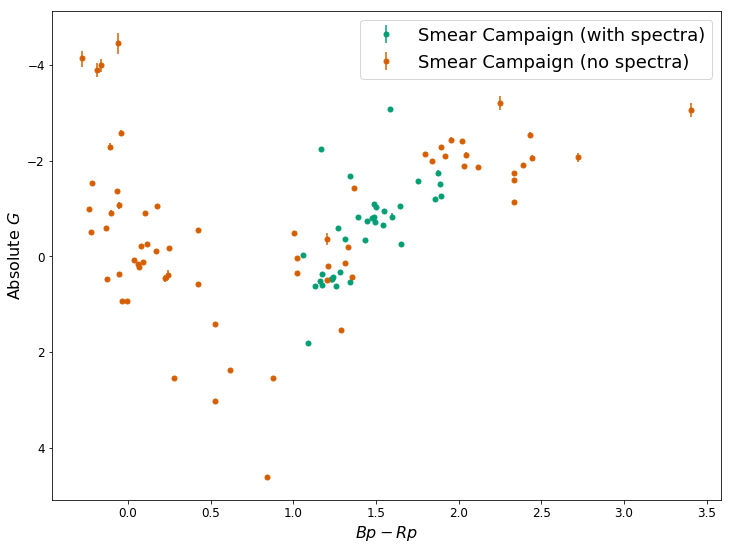

In [86]:
rc('text', usetex=False)
m = newtab['Spectroscopy']!='--'
plt.errorbar(bp[m]-rp[m],abs_gg[m],yerr=errorbars[:,m],fmt='.',color=colours[1],label=r'Smear Campaign (with spectra)',markersize=10)
plt.errorbar(bp[~m]-rp[~m],abs_gg[~m],yerr=errorbars[:,~m],fmt='.',color=colours[2],label=r'Smear Campaign (no spectra)',markersize=10)
plt.gca().invert_yaxis()
plt.xlabel(r'$Bp-Rp$')
plt.ylabel(r'Absolute $G$')
plt.legend()

Now we want to use Megan Bedell's Gaia-Kepler crossmatch to situate these in the broader colour-magnitude diagram

In [87]:
kep_data = Table.read('../data/kepler_dr2_4arcsec.fits', format='fits')


In [88]:
kep_data['abs_gmag'] = kep_data['phot_g_mean_mag'] - \
                            5.*(np.log10(kep_data['r_est']) - 1.)
kep_data['abs_gmag'].unit = u.mag

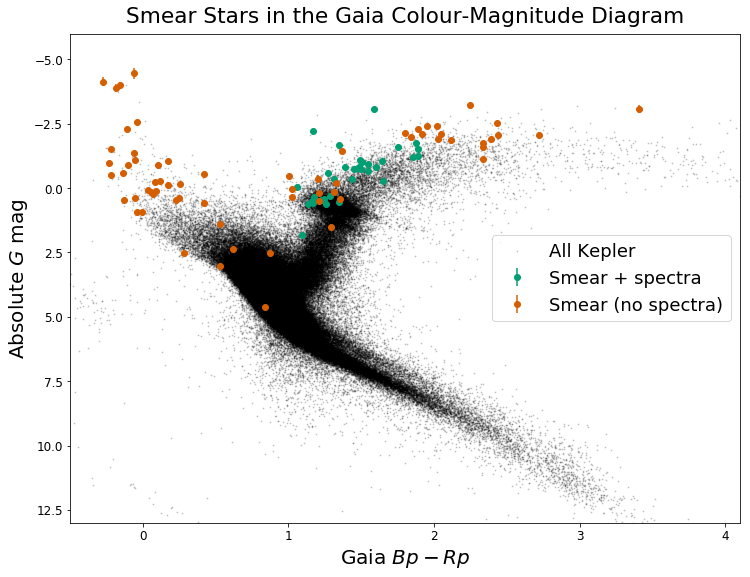

In [89]:
filter = (kep_data['phot_g_mean_mag'] <= 18.) & (kep_data['parallax'] > 0.1)
plt.scatter(kep_data['bp_rp'][filter], kep_data['abs_gmag'][filter], alpha=0.15, color='k', s=1,label='All Kepler')
m = newtab['Spectroscopy']!='--'
plt.errorbar(bp[m]-rp[m],abs_gg[m],yerr=errorbars[:,m],fmt='.',color=colours[1],label=r'Smear + spectra',markersize=12)
plt.errorbar(bp[~m]-rp[~m],abs_gg[~m],yerr=errorbars[:,~m],fmt='.',color=colours[2],label=r'Smear (no spectra)',markersize=12)

plt.xlabel('Gaia $Bp-Rp$', fontsize=20)
plt.ylabel(r'Absolute $G$ mag', fontsize=20)
plt.ylim([13,-6])
plt.xlim([-0.5,4.1])
plt.legend()
plt.title(r'Smear Stars in the Gaia Colour-Magnitude Diagram',y=1.01)
plt.savefig('../paper/gaia_kepler_hr.png')

## Now compare to Hypatia

In [90]:
Simbad.reset_votable_fields()
Simbad.add_votable_fields('ids')
sim = Simbad.query_objects(cat['Name'])
ids = sim['IDS']

In [91]:
import re
hips = []
for eyedee in ids:
    m = re.search('\|HIP  (.+?)\|',str(eyedee))
    if m:
        found = m.group(1)
    print found
    hips.append(found)

In [92]:
hinkel = Table.read('../data/hypatia-03082018.csv')

In [93]:
in_hyp = []
for j, hip in enumerate(hips):
    if int(hip) in hinkel['f_hip']:
        print hip, sim['MAIN_ID'][j]
        in_hyp.append((hip,sim['MAIN_ID'][j]))

In [94]:
in_hyp

[('96459', 'HD 185351'), ('92831', 'HD 175740')]

In [95]:
sim

MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,IDS
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,,
object,unicode13,unicode13,int16,int16,float32,float32,int16,unicode1,unicode1,object,object
HD 185351,19 36 37.9763,+44 41 41.760,14,14,0.068,0.079,90,A,O,2018yCat.1345....0G,HD 185351|AG+44 1630|BD+44 3185|GC 27140|GCRV 12021|GEN# +1.00185351|GSC 03147-01921|HIC 96459|HIP 96459|HR 7468|IRAS 19350+4434|KIC 8566020|2MASS J19363801+4441418|PLX 4610|PLX 4610.00|PPM 58585|ROT 2826|1RXS J193637.6+444137|SAO 48649|SKY# 36595|SPOCS 3088|TD1 25124|TYC 3147-1921-1|UBV 16672|UBV M 23982|WEB 16922|Gaia DR2 2078403295235690112
HD 186155,19 40 50.1834,+45 31 29.780,14,14,0.149,0.149,90,A,O,2018yCat.1345....0G,HD 186155|AG+45 1570|BD+45 2949|CCDM J19409+4531A|CSI+45 2949 1|FK5 3575|GC 27249|GCRV 12073|GEN# +1.00186155|GSC 03556-03772|HIC 96825|HIP 96825|HR 7495|IDS 19378+4517 A|IRAS 19392+4524|2MASS J19405016+4531295|NSV 12300|PLX 4627|PLX 4627.00|PPM 58681|ROT 2834|SAO 48718|SKY# 36771|TD1 25272|TYC 3556-3772-1|UBV 16750|UBV M 24056|uvby98 100186155|WDS J19408+4532A|WEB 16993|Gaia DR2 2079990268465009024|Gaia DR1 2079990264172082304
HD 175740,18 54 52.1775,+41 36 09.793,14,14,0.075,0.082,90,A,O,2018yCat.1345....0G,HD 175740|ADS 11840 A|AG+41 1639|AKARI-IRC-V1 J1854521+413610|BD+41 3177|CCDM J18549+4136A|CSI+41 3177 1|GC 25972|GCRV 11379|GEN# +1.00175740|GSC 03127-02260|HIC 92831|HIP 92831|HR 7146|IDS 18517+4128 A|IRAS 18532+4132|IRC +40333|2MASS J18545217+4136098|PPM 57629|SAO 47909|SKY# 34837|TD1 23531|TYC 3127-2260-1|UBV M 23335|WDS J18549+4136A|WEB 16069|Gaia DR2 2104485016711846656
HD 184875,19 34 41.2618,+42 24 45.039,14,14,0.088,0.102,90,A,O,2018yCat.1345....0G,HD 184875|AG+42 1724|BD+42 3386|CEL 4789|GC 27070|GCRV 11989|GEN# +1.00184875|GSC 03143-02179|HIC 96288|HIP 96288|HR 7444|IRAS 19330+4218|2MASS J19344127+4224448|PLX 4597|PLX 4597.00|PPM 58526|ROT 2819|SAO 48601|SKY# 36507|TD1 25018|TYC 3143-2179-1|UBV 16624|uvby98 100184875|WEB 16880|Gaia DR2 2077737571001053312|Gaia DR1 2077737571001053312
* 14 Cyg,19 39 26.4883,+42 49 05.781,14,14,0.157,0.163,90,A,O,2018yCat.1345....0G,* 14 Cyg|AG+42 1737|AKARI-IRC-V1 J1939264+424906|ALS 16589|BD+42 3413|CEL 4812|FK5 3572|GC 27213|GCRV 12052|GEN# +1.00185872|GSC 03143-02178|HD 185872|HIC 96693|HIP 96693|HR 7483|IRAS 19378+4242|2MASS J19392648+4249057|N30 4351|PLX 4622.1|PLX 4622.10|PPM 58649|Renson 51260|ROT 2831|SAO 48691|SKY# 36703|TD1 25222|TYC 3143-2178-1|UBV 16723|UBV M 24029|uvby98 100185872|WEB 16963|Gaia DR2 2077959092540451456|Gaia DR1 2077959088236964736
HD 189178,19 57 13.8676,+40 22 04.171,14,14,0.079,0.112,90,A,O,2018yCat.1345....0G,HD 189178|AG+40 1935|BD+39 3968|CCDM J19572+4022A|FK5 3593|GC 27649|GCRV 12312|GEN# +1.00189178|GSC 03141-03693|HGAM 813|HIC 98194|HIP 98194|HR 7628|IDS 19538+4006 A|2MASS J19571387+4022041|N30 4414|PPM 59089|Renson 52400|ROT 2890|SAO 49011|SBC9 1191|SKY# 37388|TD1 25781|TYC 3141-3693-1|UBV 17030|UBV M 24342|uvby98 100189178|WDS J19572+4022A|WEB 17314|Gaia DR2 2073537612700605696
...,...,...,...,...,...,...,...,...,...,...,...
BD+43 3068,18 46 17.7487,+43 48 56.392,14,14,0.035,0.038,90,A,O,2018yCat.1345....0G,BD+43 3068|AG+43 1566|GSC 03130-02191|2MASS J18461773+4348564|PPM 57477|SAO 47785|TYC 3130-2191-1|Gaia DR2 2117267079903573504|Gaia DR1 2117267075604798080


In [96]:
# import altair as alt
import pandas as pd

In [97]:
pdg = gaia.to_pandas()
pdg.assign(bprp=pdg.bp - pdg.rp);
pdg.insert(len(pdg.columns), 'bprp', pd.Series(pdg.bp-pdg.rp, index=pdg.index))
pdg.insert(len(pdg.columns), 'name', pd.Series(sim['MAIN_ID'], index=pdg.index))
spec = ['TRES' if sp==1 else 'No  Spectra' for sp in newtab['Spectroscopy']!='--']
pdg.insert(len(pdg.columns), 'Spectroscopy', pd.Series(spec, index=pdg.index))
pdg.insert(len(pdg.columns), 'SpType', pd.Series(newcat['SpType'], index=pdg.index))

# pdkep = kep_data.to_pandas()

In [98]:
# # background = alt.Chart(pdkep).mark_point().encode(
# #     x='bp_rp',
# #     y='abs_gmag').properties(alpha=0.2)
# xrange = (-0.5,4.1)
# yrange = (13,-6)

# smear_chart = alt.Chart(pdg).mark_circle().encode(
#     alt.X('bprp',scale=alt.Scale(domain=xrange,clamp=True)),
#     alt.Y('abs_gg',scale=alt.Scale(domain=yrange,clamp=True)),
#     tooltip='name',
#     color='Spectroscopy',
#     size=alt.value(42)
# )


In [99]:
# smear_chart

In [100]:
# background = alt.Chart(pdkep).mark_rect().encode(
#     alt.X('bp_rp',scale=alt.Scale(domain=xrange,clamp=True),bins=alt.Bin(maxbins=50)),
#     alt.Y('abs_gmag',scale=alt.Scale(domain=yrange,clamp=True),bins=alt.Bin(maxbins=50))
# )


### The *Kepler* dataset is too big for Altair. But not for Bokeh - let's copy from at demo.ipynb from github.com/megbedell/gaia-kepler.fun

In [108]:
from bokeh.plotting import *
from bokeh.io import output_notebook
from bokeh.models import OpenURL, Circle, HoverTool, PanTool, BoxZoomTool, ResetTool, SaveTool, TapTool, WheelZoomTool
from bokeh.util.hex import hexbin
from bokeh.transform import linear_cmap, factor_cmap
from bokeh.palettes import Spectral6
reset_output()
output_file("cmd_smear.html")
# output_notebook()

In [109]:
filter1 = (kep_data['phot_g_mean_mag'] <= 18.) & (kep_data['parallax_over_error'] > 25)
filter2 = (kep_data['planet?'] == 'conf') & filter1

filter2 = filter1 

thin = 4

source = ColumnDataSource(
    data=dict(
        kepid=kep_data[filter2]['kepid'].data.data[::thin],
        kepmag=kep_data[filter2]['kepmag'].data.data[::thin],
        bp_rp=kep_data[filter2]['bp_rp'].data.data[::thin],
        abs_gmag=kep_data[filter2]['abs_gmag'].data.data[::thin],
        mass=kep_data[filter2]['mass'].data.data[::thin],
        radius=kep_data[filter2]['radius'].data.data[::thin]
        )
    )

source_smear = ColumnDataSource(
    data=dict(
        name=pdg.name.values,
        abs_gmag=pdg.abs_gg.values,
        bp_rp=pdg.bprp.values,
        spec=pdg.Spectroscopy.values,
        sptype=pdg.SpType.values
        )
    )


In [110]:
%%time
xrange = (-0.5,4.1)
yrange = (13,-6)

fig = figure(tools="wheel_zoom,pan,reset",x_range=xrange,
        y_range=yrange,title="Smear Stars in the Gaia Colour-Magnitude Diagram")   
kep_render = fig.circle('bp_rp','abs_gmag', source=source, size=4, name='KICs',color='black',alpha=0.2)

smear_render = fig.circle('bp_rp','abs_gmag', source=source_smear, size=10, name='Smear',
                          color=factor_cmap('spec',palette=Spectral6,factors=pdg.Spectroscopy.values),legend='spec')
hover = HoverTool(renderers=[smear_render],
                    tooltips=[
        ("Name", "@name"),
        ("Sp. Type","@sptype"),
        ("Abs. G mag","@abs_gmag"),
        ("Bp-Rp","@bp_rp")
                            ]
    )
fig.add_tools(hover)
fig.legend.orientation = "vertical"
fig.legend.location = "bottom_left"

fig.xaxis.axis_label = 'Gaia Bp-Rp (mag)'
fig.yaxis.axis_label = 'Gaia Abs. G Mag'
fig.xaxis.axis_label_text_font_size = '14pt'
fig.xaxis.major_label_text_font_size = '12pt'
fig.yaxis.axis_label_text_font_size = '14pt'   
fig.yaxis.major_label_text_font_size = '12pt' 
# save(fig)
show(fig)


In [104]:
for j, star in enumerate(pdg.name.values):
    print j, star, pdg.abs_gg.values[j]